Dataset Overview:
          Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Win

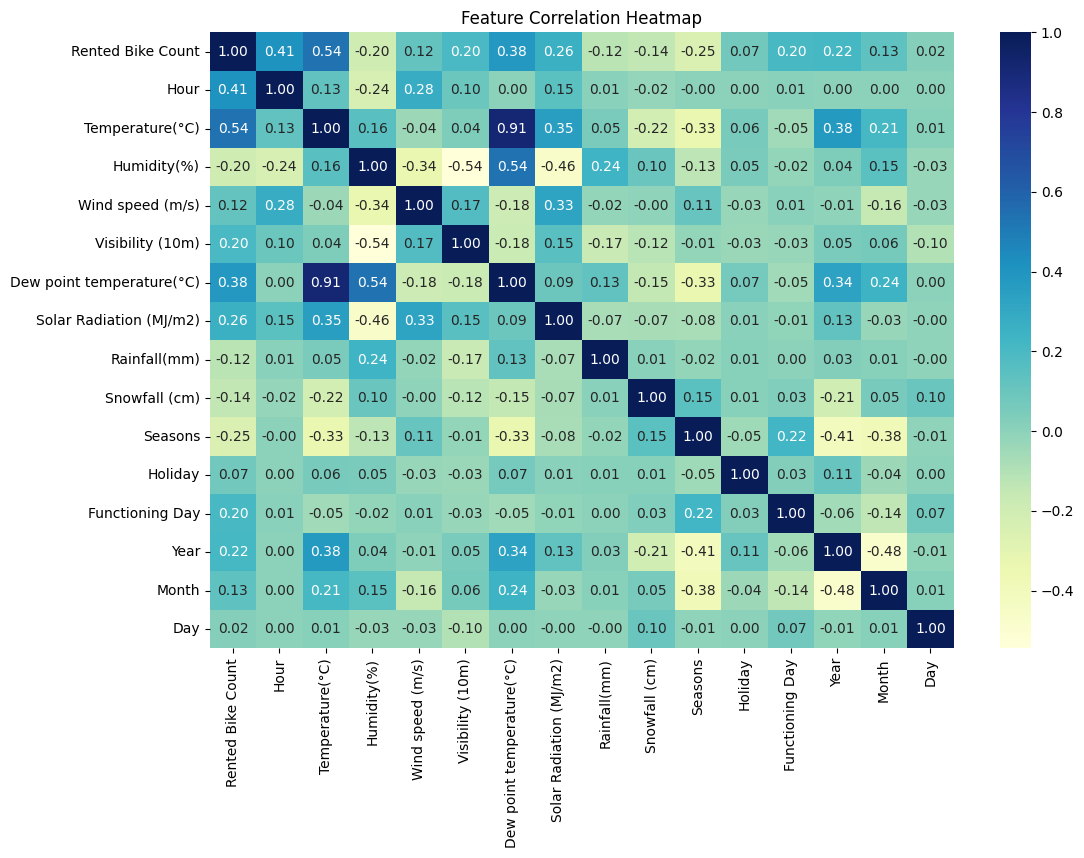

Decision Tree - MAE: 187.00, RMSE: 325.70, R^2: 0.75
KNN - MAE: 212.53, RMSE: 337.00, R^2: 0.74
Random Forest - MAE: 143.61, RMSE: 235.77, R^2: 0.87
Gradient Boosting - MAE: 184.19, RMSE: 273.88, R^2: 0.83
XGBoost - MAE: 146.38, RMSE: 239.81, R^2: 0.87


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


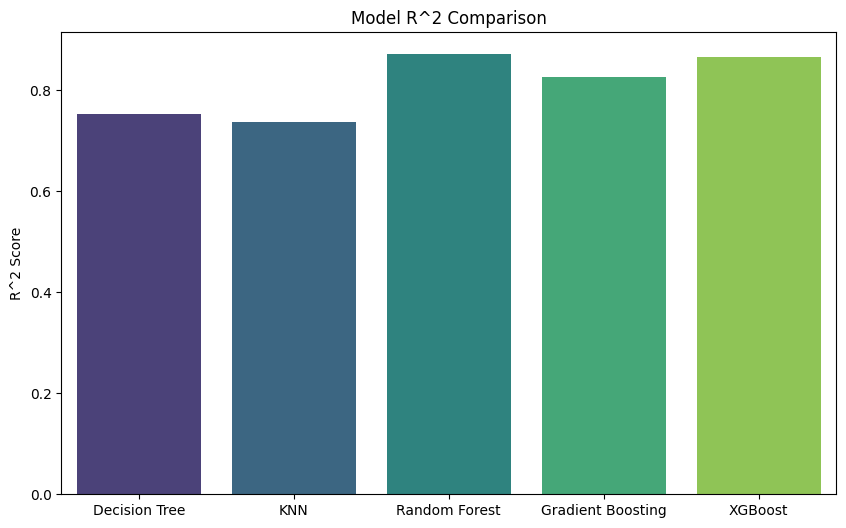

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

# Load the dataset
dataset = pd.read_csv('/kaggle/input/seoul-bike-sharing-demand-prediction/SeoulBikeData.csv', encoding='ISO-8859-1')

print("Dataset Overview:\n", dataset.head())
print("\nNumber of features:", dataset.shape[1])
print("Number of data points:", dataset.shape[0])
print("\nFeature types:\n", dataset.dtypes)

# Introduce missing values in the dataset
np.random.seed(42)
cols_to_alter = ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)']
for col in cols_to_alter:
    dataset.loc[dataset.sample(frac=0.1).index, col] = np.nan

# Preprocess date column
if 'Date' in dataset.columns:
    dataset['Date'] = pd.to_datetime(dataset['Date'], format='%d/%m/%Y')
    dataset['Year'] = dataset['Date'].dt.year
    dataset['Month'] = dataset['Date'].dt.month
    dataset['Day'] = dataset['Date'].dt.day
    dataset.drop('Date', axis=1, inplace=True)

# Label encode categorical columns
categorical_columns = dataset.select_dtypes(include=['object']).columns
for col in categorical_columns:
    label_encoder = LabelEncoder()
    dataset[col] = label_encoder.fit_transform(dataset[col])

# Check for missing values
print("\nMissing values:\n", dataset.isnull().sum())

# Visualize feature correlations
correlation_matrix = dataset.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

# Scale numerical features
scaler = MinMaxScaler()
numeric_features = dataset.select_dtypes(include=['int64', 'float64']).columns
input_features = numeric_features.drop('Rented Bike Count', errors='ignore')
dataset[input_features] = scaler.fit_transform(dataset[input_features])

# Split the dataset into train and test sets
X = dataset.drop('Rented Bike Count', axis=1)
y = dataset['Rented Bike Count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Impute missing values
imputer = SimpleImputer(strategy='most_frequent')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Define a function to evaluate models
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R^2: {r2:.2f}")
    return mae, rmse, r2

# Decision Tree Regressor
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_metrics = evaluate_model("Decision Tree", y_test, dt_predictions)

# KNN Regressor
knn_model = KNeighborsRegressor(n_neighbors=1)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
knn_metrics = evaluate_model("KNN", y_test, knn_predictions)

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_metrics = evaluate_model("Random Forest", y_test, rf_predictions)

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
gb_metrics = evaluate_model("Gradient Boosting", y_test, gb_predictions)

# XGBoost Regressor
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_metrics = evaluate_model("XGBoost", y_test, xgb_predictions)

# Compare R^2 scores across models
models = ['Decision Tree', 'KNN', 'Random Forest', 'Gradient Boosting', 'XGBoost']
r2_scores = [dt_metrics[2], knn_metrics[2], rf_metrics[2], gb_metrics[2], xgb_metrics[2]]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=r2_scores, palette='viridis')
plt.title('Model R^2 Comparison')
plt.ylabel('R^2 Score')
plt.show()
